In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import xarray as xr

from utils import normalize

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictor

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fetch = False
if fetch:
    import sys 
    sys.path.append('/Users/zach/Library/CloudStorage/OneDrive-UniversityofWaterloo/Documents/MASc/test')

    import datetime 
    from glorys import get_glorys

    ds = get_glorys()
    ds = ds.sel(latitude=slice(51, 70), longitude=slice(-95, -65))[['siconc']]
    ds = ds.sel(time=slice(datetime.datetime(2013, 1, 1), datetime.datetime(2018, 1, 1)))
else:
    ds = xr.open_dataset('data/glorys.nc')

In [3]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 3
output_timesteps= 1

def xarray_to_x_y(da, start_date, end_date, input_timesteps, output_timesteps, coarsen=0):
    if coarsen != 0:
        da = da.coarsen(latitude=coarsen, longitude=coarsen, boundary='trim').mean()
    num_samples = da.time.size-output_timesteps-input_timesteps
    i = 0
    x = np.ndarray((num_samples, input_timesteps, da.latitude.size, da.longitude.size))
    y = np.ndarray((num_samples, output_timesteps, da.latitude.size, da.longitude.size))
    while i + output_timesteps + input_timesteps < da.time.size:
        x[i] = np.nan_to_num(da.isel(time=slice(i, i+input_timesteps)).values)
        y[i] = np.nan_to_num(da.isel(time=slice(i+input_timesteps, i+input_timesteps+output_timesteps)).values)
        i += 1
    
    # x, y = np.nan_to_num(x), np.nan_to_num(y)
    x, y = np.expand_dims(x, -1), np.expand_dims(y, -1)
    return x, y
    
coarsen=4
x, y = xarray_to_x_y(ds.siconc, datetime.datetime(2013, 1, 1), datetime.datetime(2016, 1, 1), input_timesteps, output_timesteps, coarsen=coarsen)
x_test, y_test = xarray_to_x_y(ds.siconc, datetime.datetime(2016, 1, 1), datetime.datetime(2017, 1, 1), input_timesteps, output_timesteps, coarsen=coarsen)
x_val, y_val = xarray_to_x_y(ds.siconc, datetime.datetime(2017, 1, 1), datetime.datetime(2018, 1, 1), input_timesteps, output_timesteps, coarsen=coarsen)

In [5]:
model_kwargs = dict(
    hidden_size=64,
    dropout=0.1,
    multi_step_loss=output_timesteps,
    input_timesteps=input_timesteps
    )

model = NextFramePredictor(experiment_name='test', decompose=True, input_features=1, integrated_space_time=False, **model_kwargs)
model.get_n_params()

71364

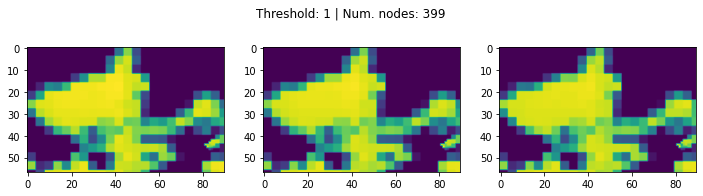

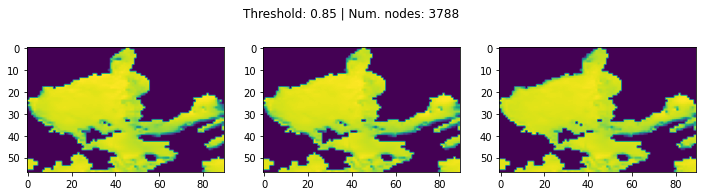

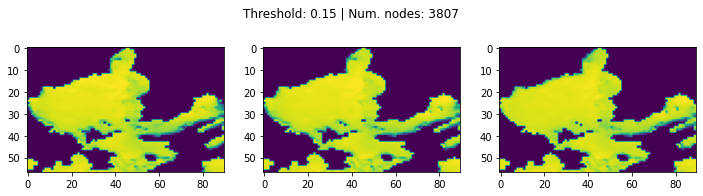

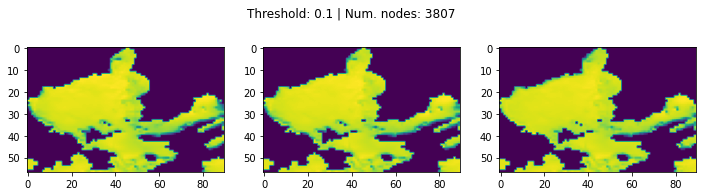

In [6]:
frame_index = 1

fig, axs = model.test_threshold(x[:10], thresh=1, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x[:10], thresh=0.85, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x[:10], thresh=0.15, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x[:10], thresh=0.1, frame_index=frame_index)
plt.show()

# fig, axs = model.test_threshold(x, thresh=0.01, frame_index=frame_index)
# plt.show()

# fig, axs = model.test_threshold(x, thresh=0.001, frame_index=frame_index)
    # plt.show()

In [ ]:
# model = NextFramePredictor(experiment_name='test', decompose=True, input_features=1, integrated_space_time=False, **model_kwargs)

model.set_thresh(0.1)  # Set the threshold based on the plots above
# model.set_thresh(-np.inf)  # Set the threshold based on the plots above

lr = 0.01

model.model.train()
model.train(x[:365], y[:365], x_test, y_test, lr=lr, n_epochs=15)  # Train for 20 epochs

# model.model.eval()
# model.score(x_val, y_val[:, :1])  # Check the MSE on the validation set

<AxesSubplot: >

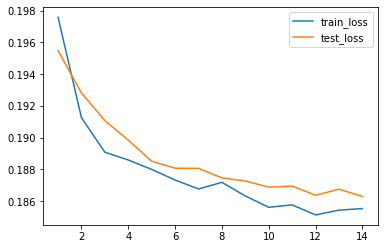

In [65]:
model.loss.iloc[1:].plot()
model.loss.to_csv('ice_results/loss.csv')

In [67]:
ar_steps = 90

launch_step = 90

# Get predictions on the validation set
model.model.eval()
y_hat = model.predict(x_val[[launch_step]], ar_steps)

100%|██████████| 90/90 [00:05<00:00, 16.24it/s]


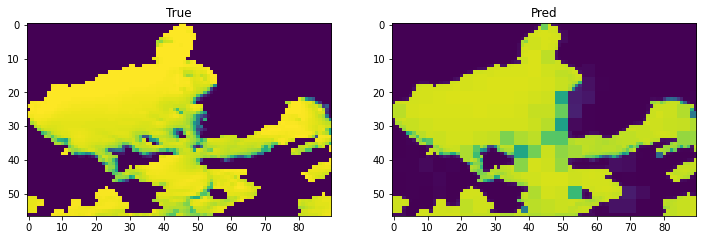

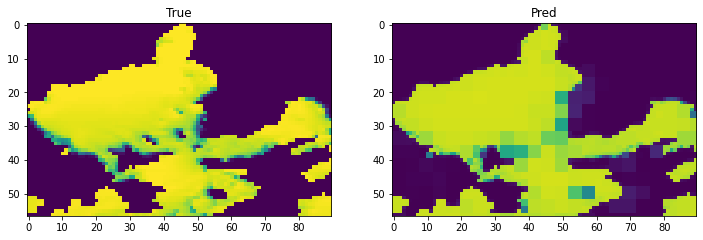

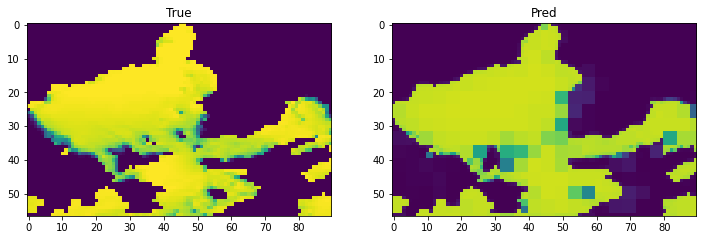

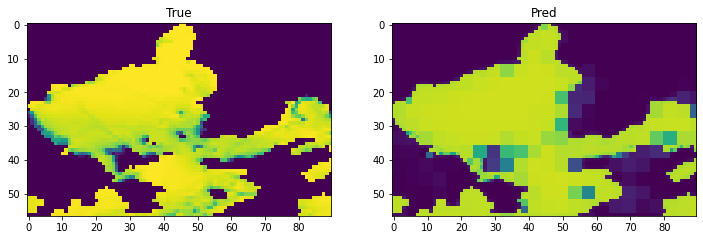

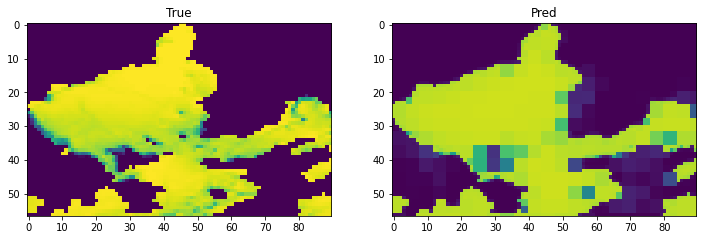

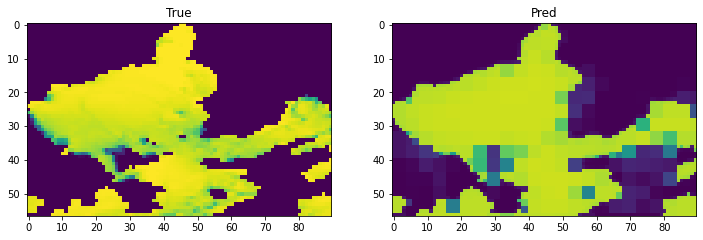

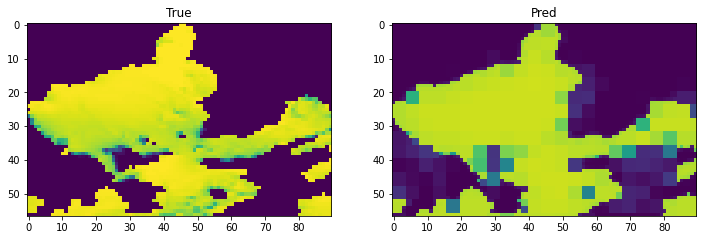

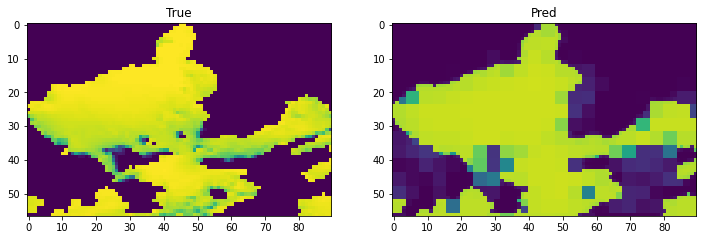

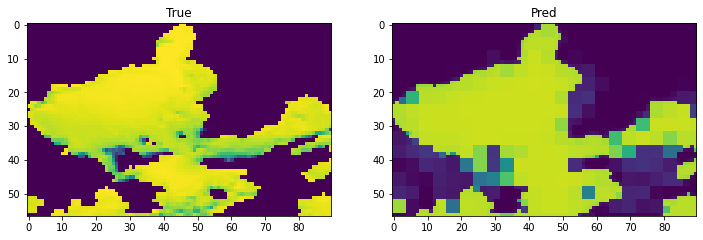

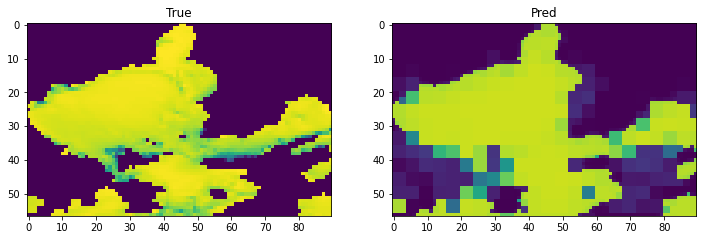

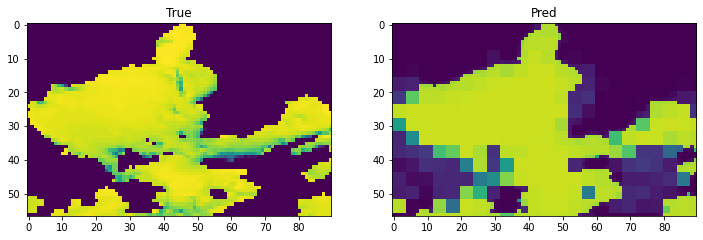

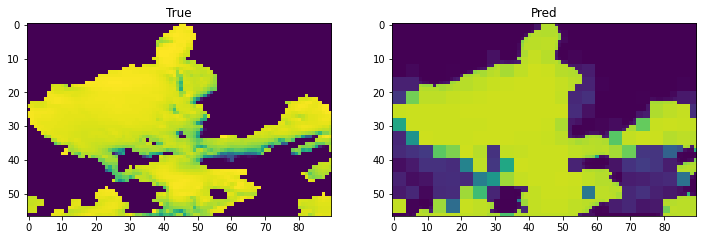

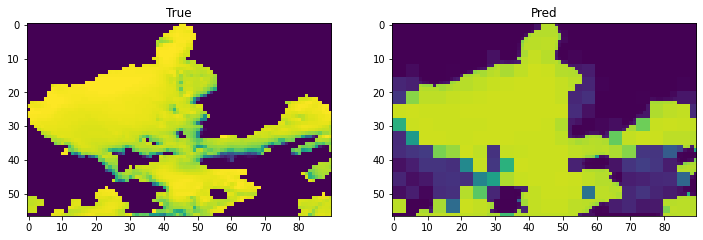

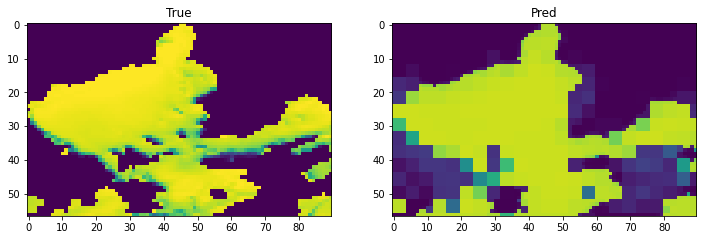

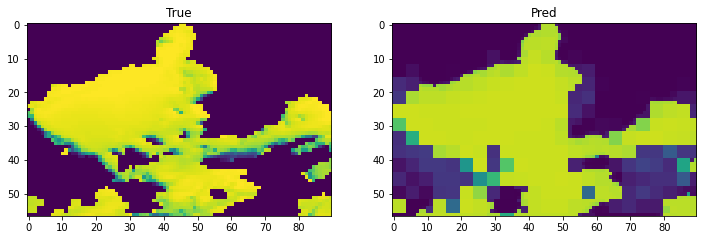

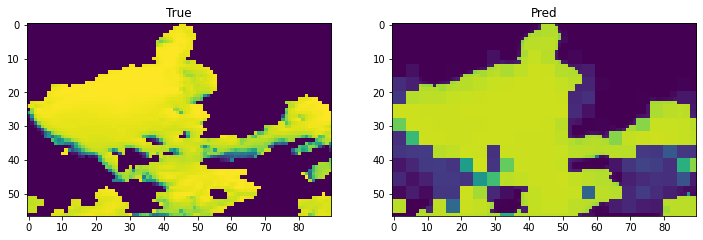

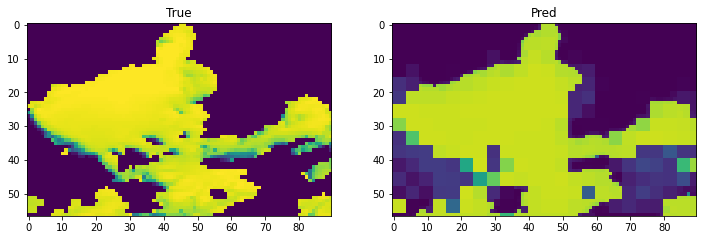

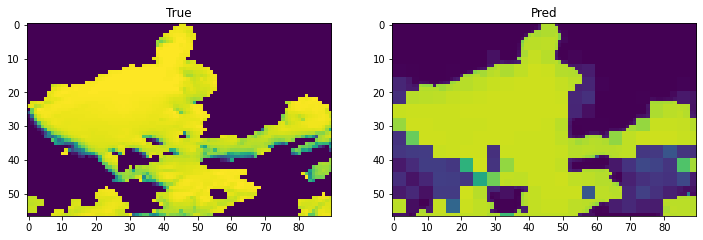

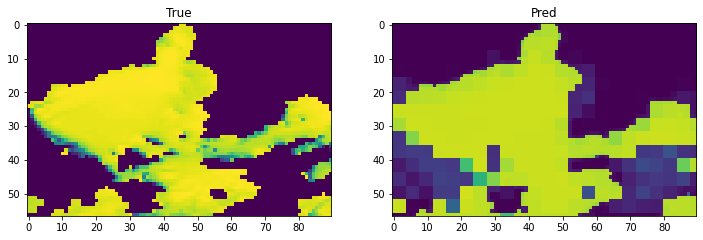

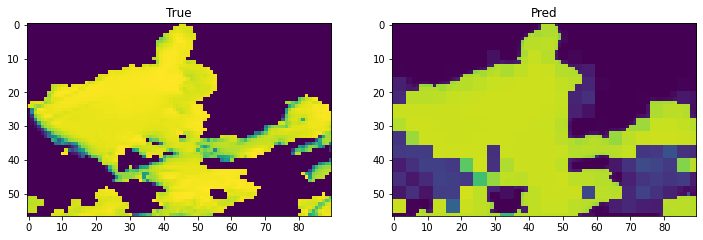

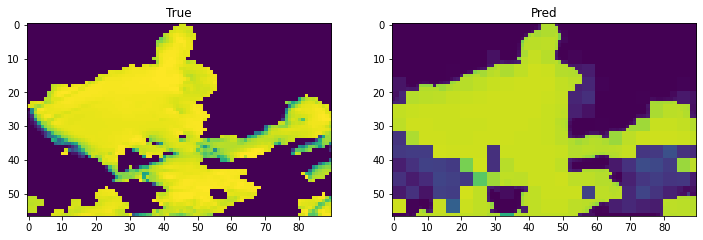

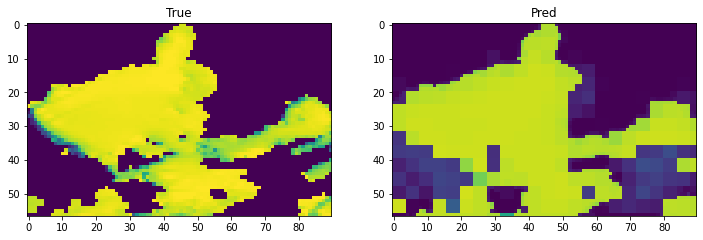

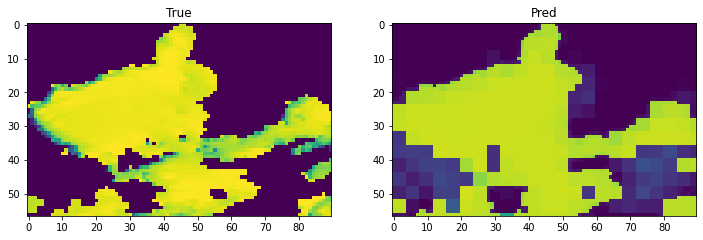

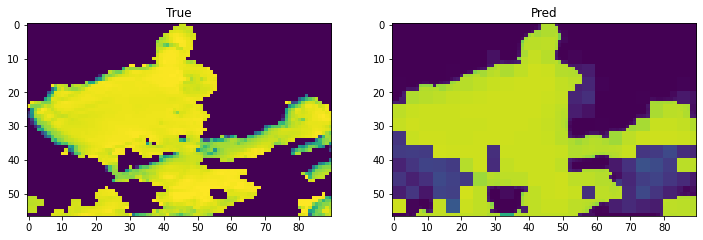

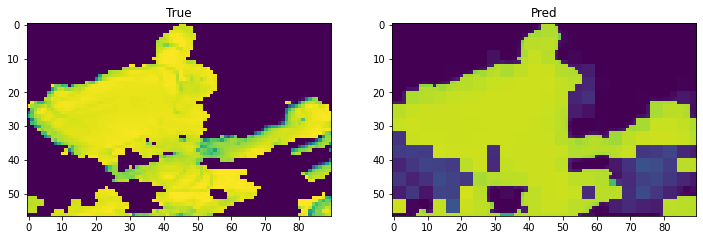

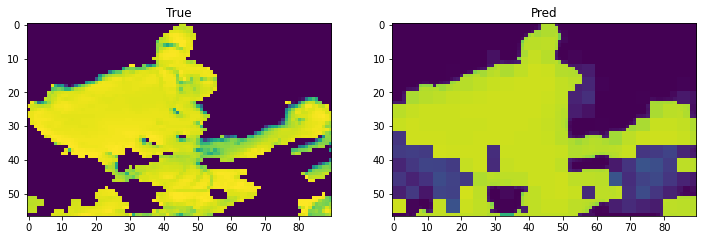

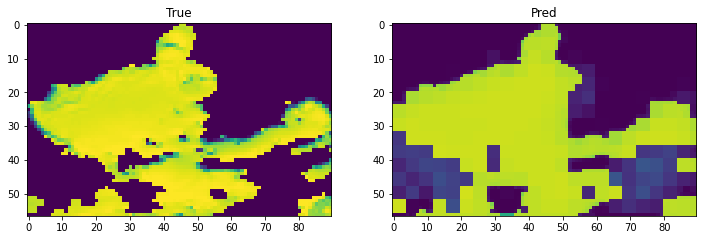

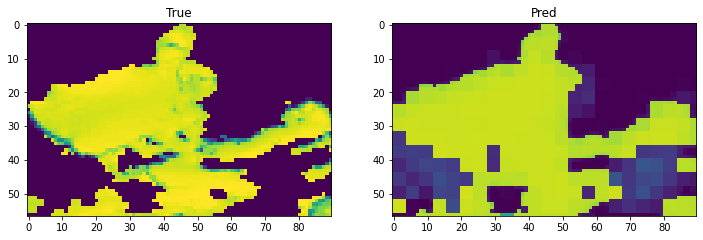

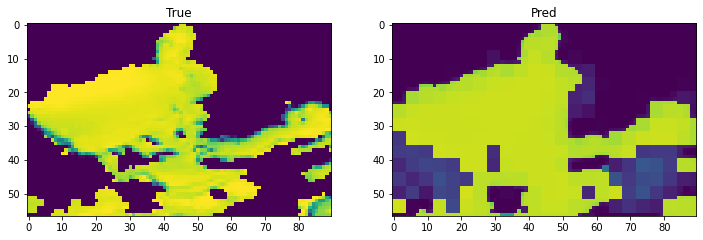

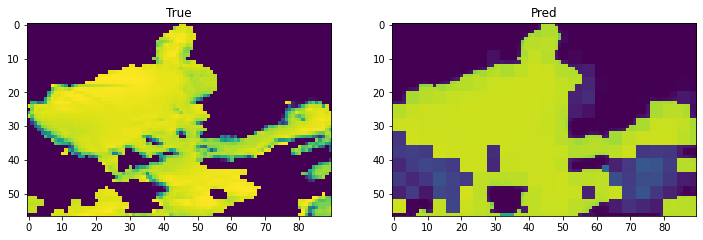

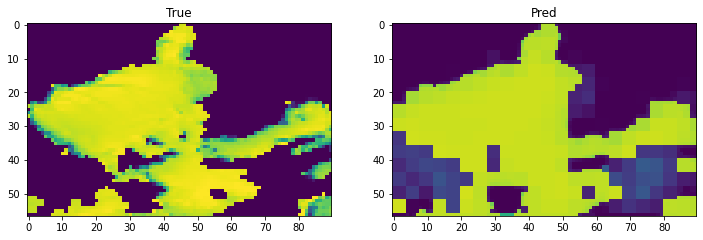

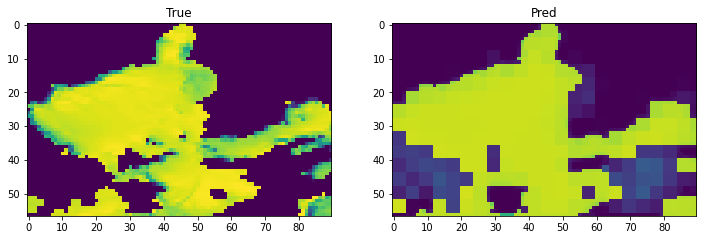

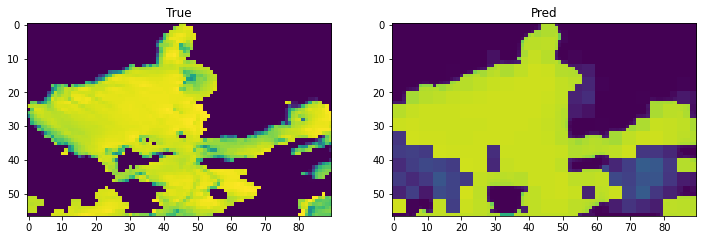

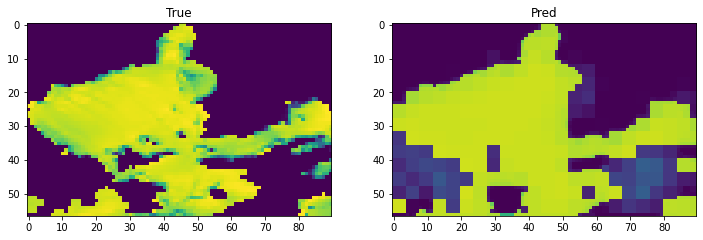

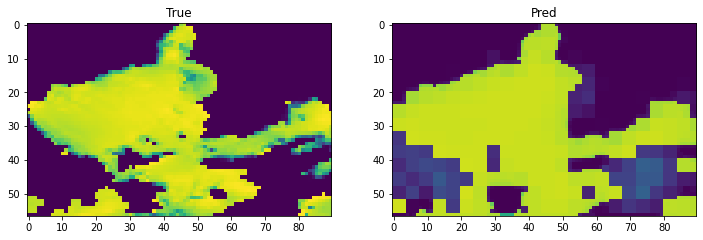

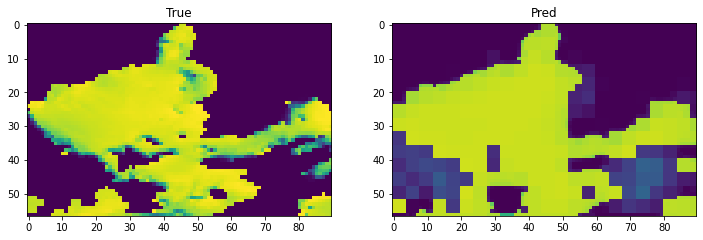

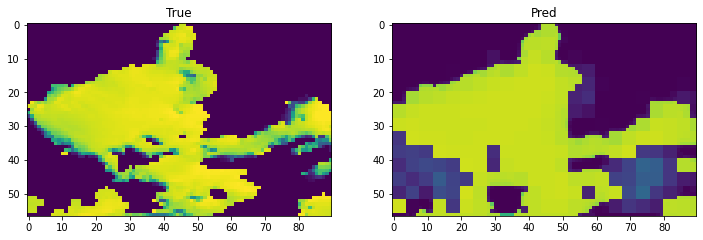

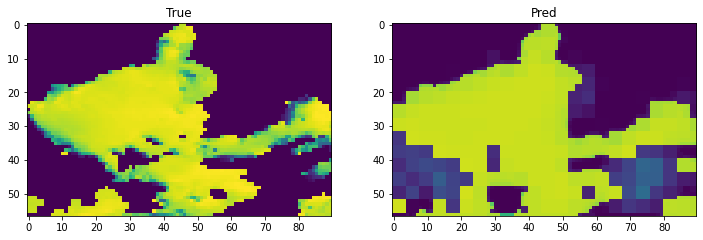

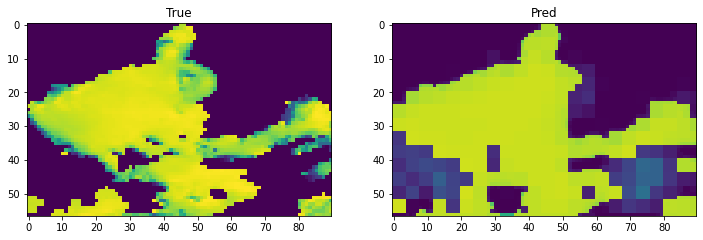

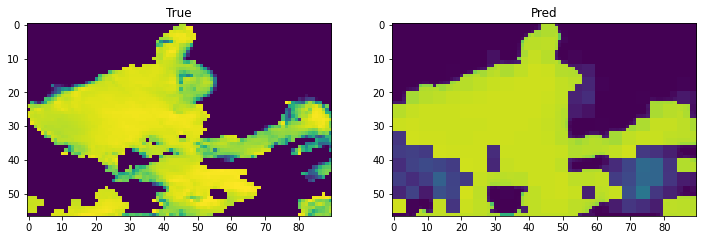

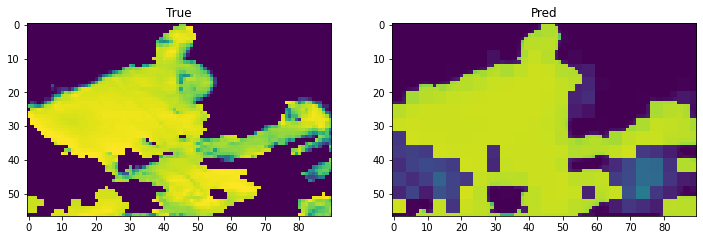

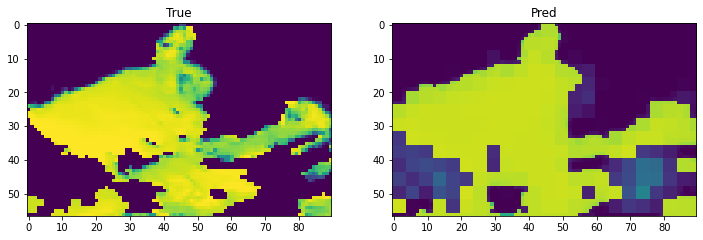

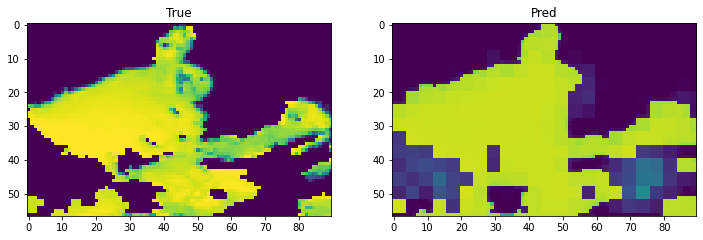

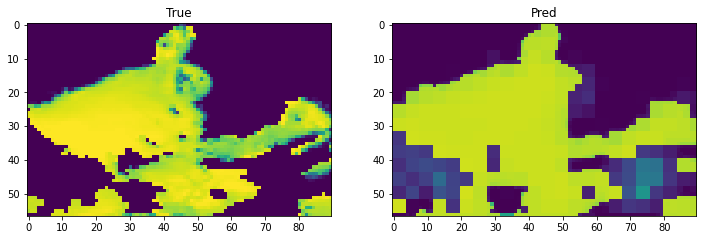

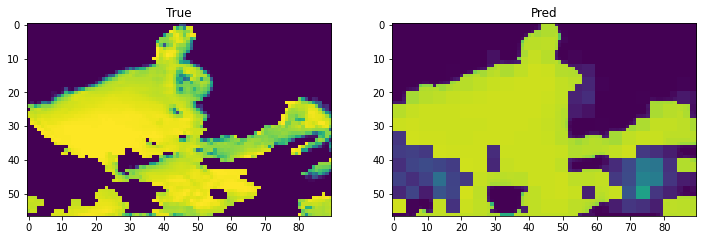

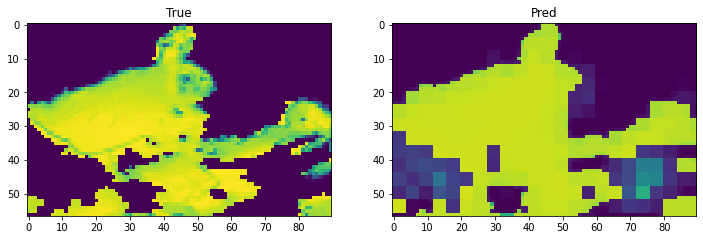

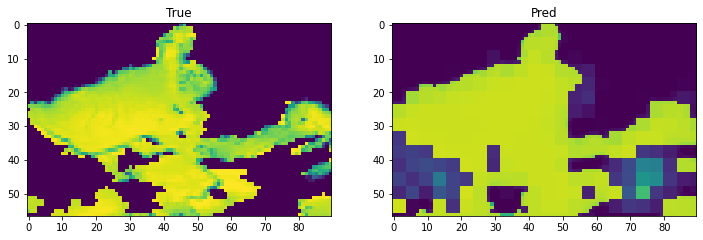

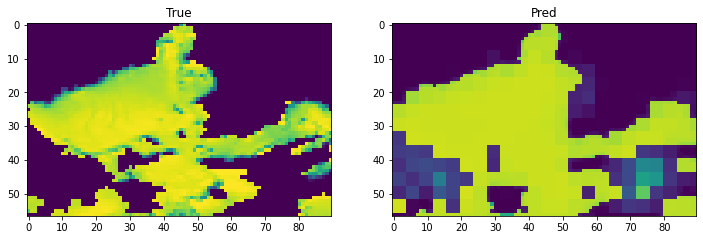

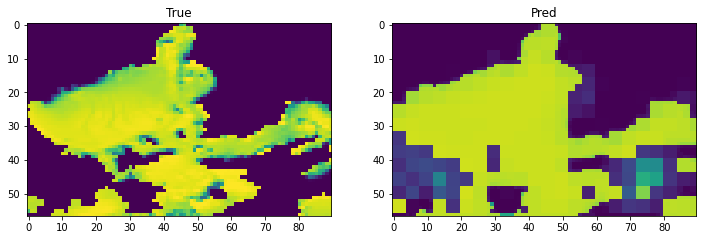

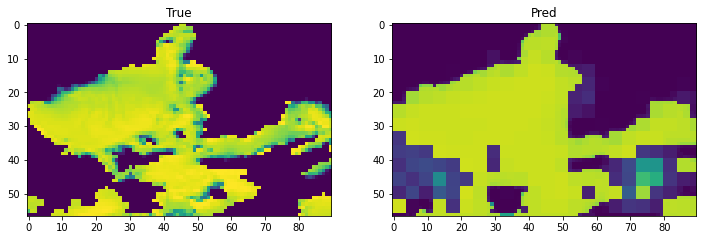

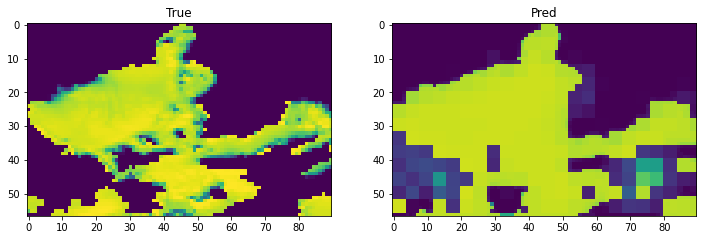

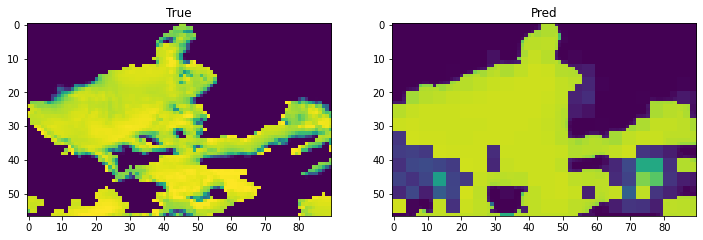

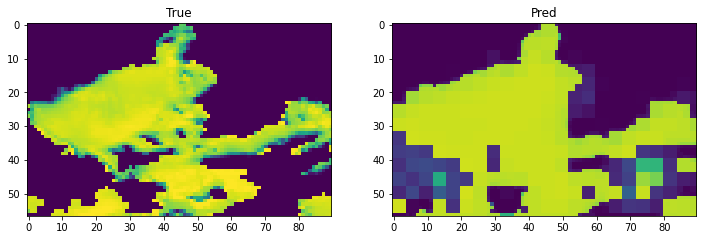

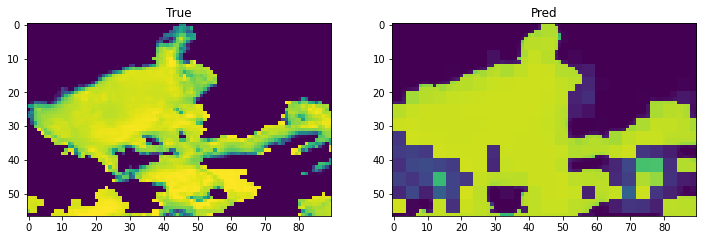

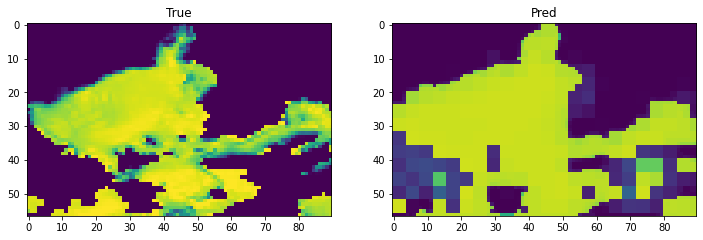

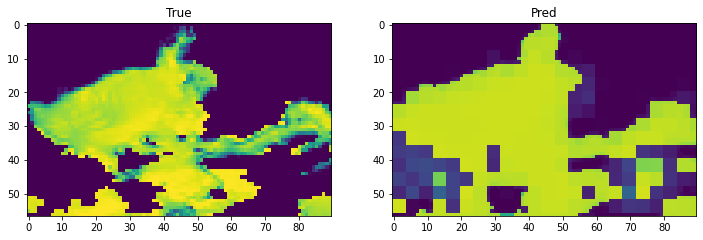

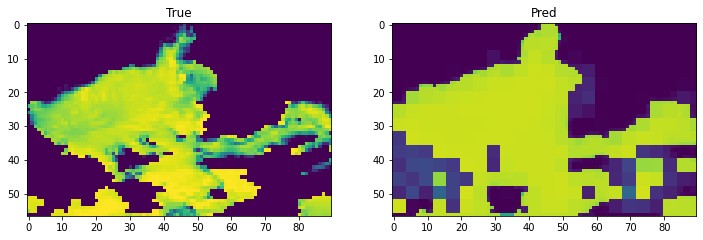

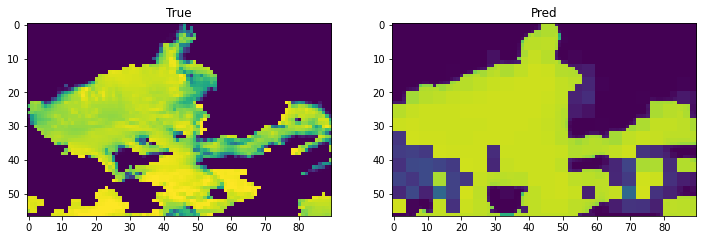

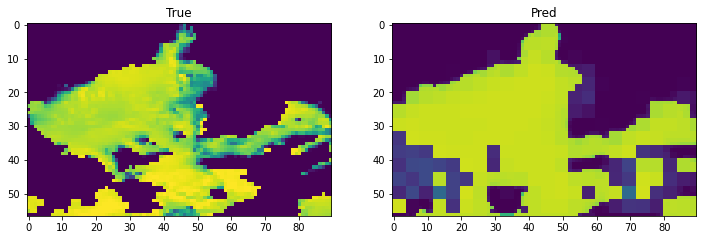

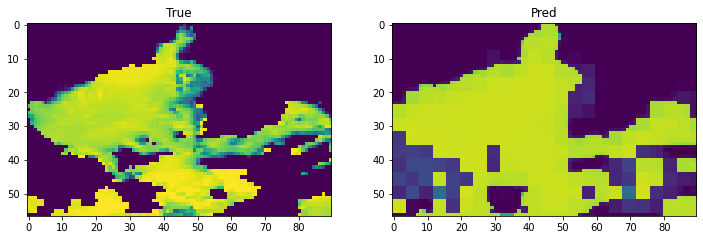

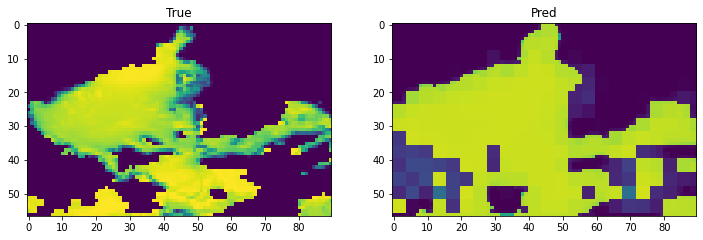

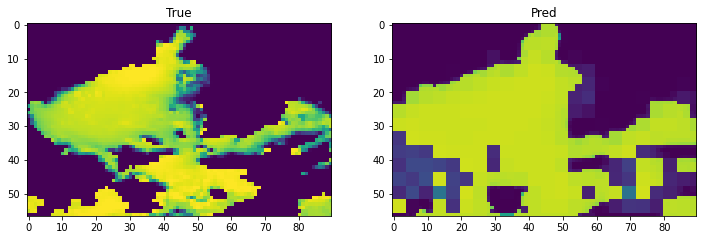

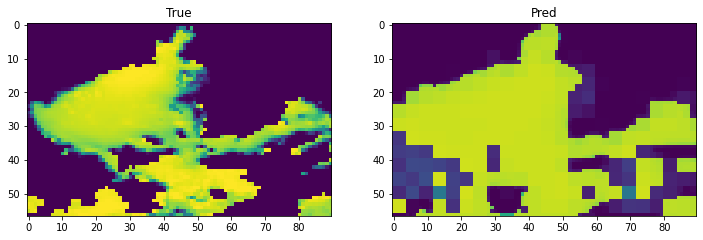

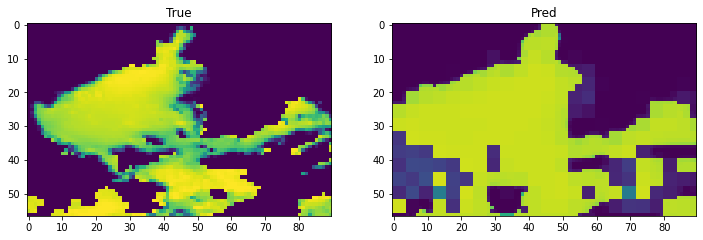

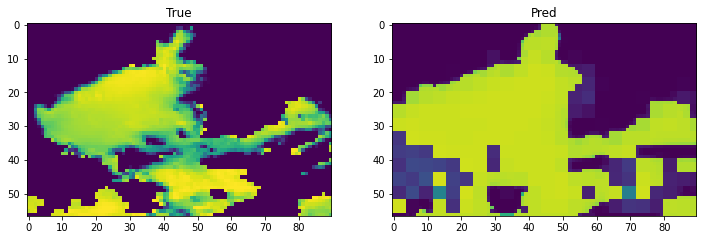

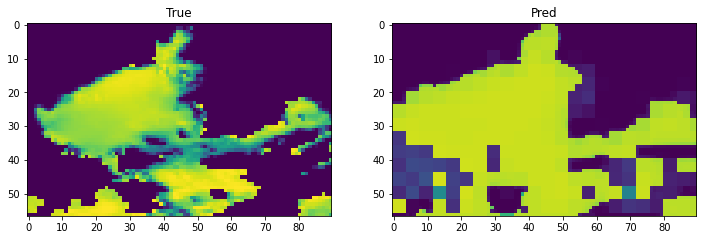

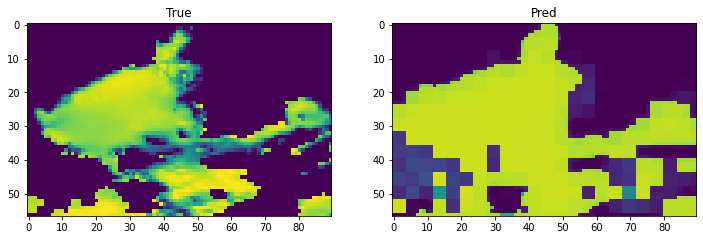

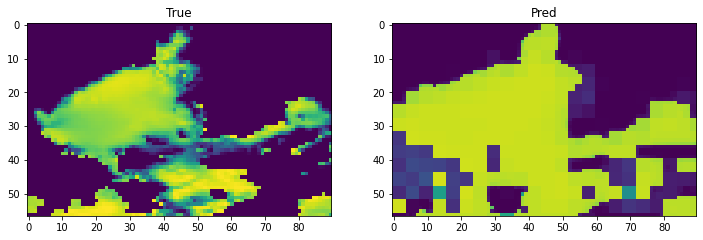

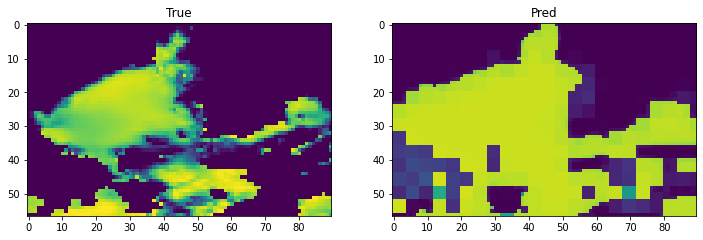

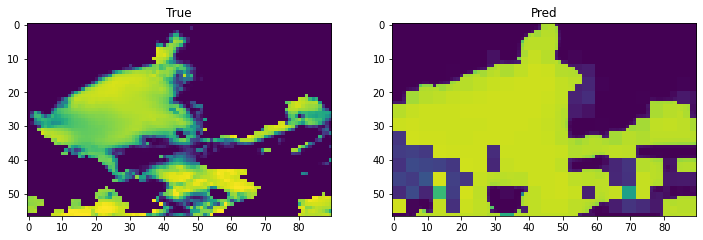

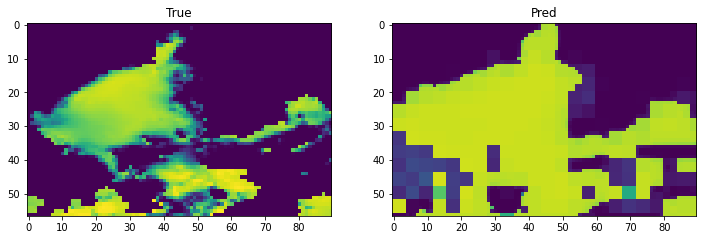

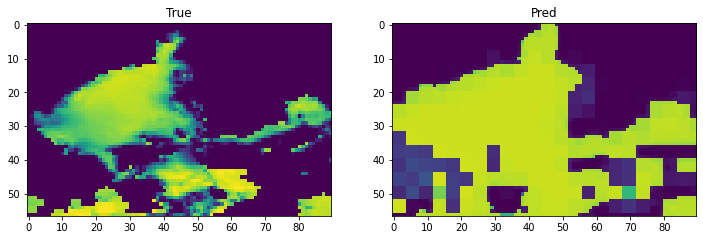

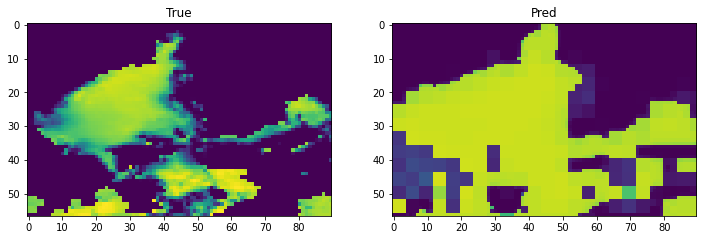

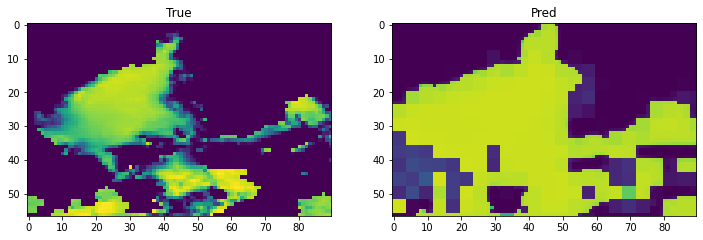

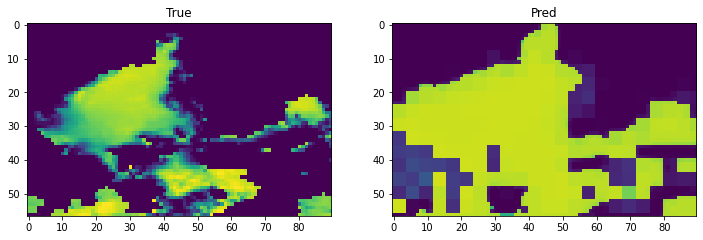

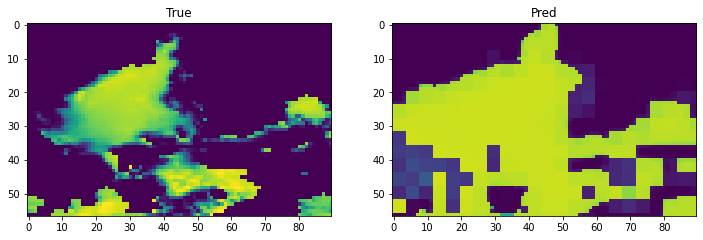

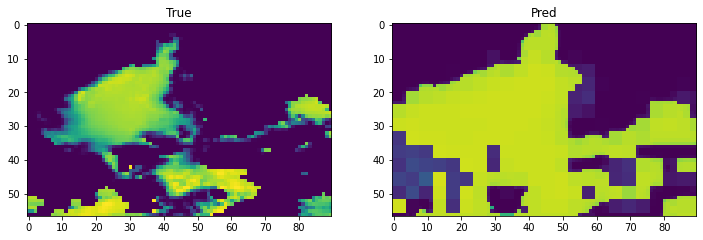

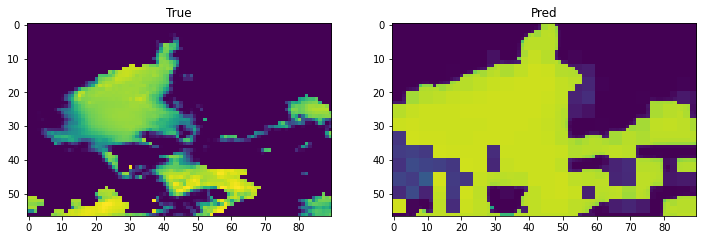

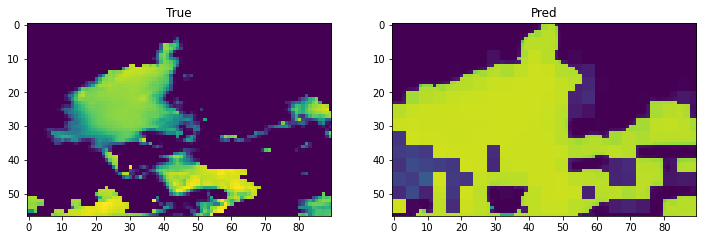

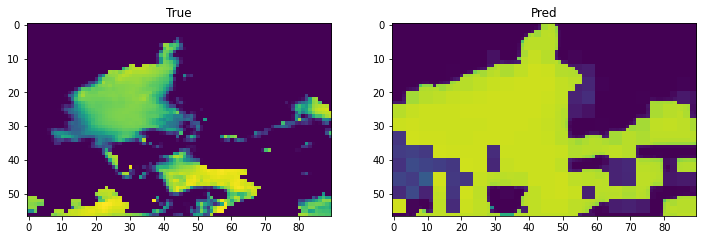

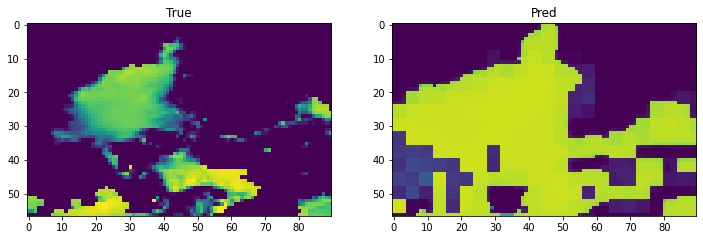

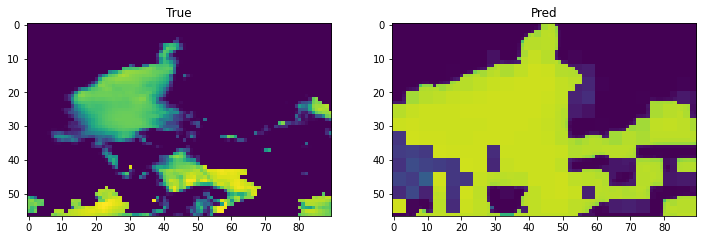

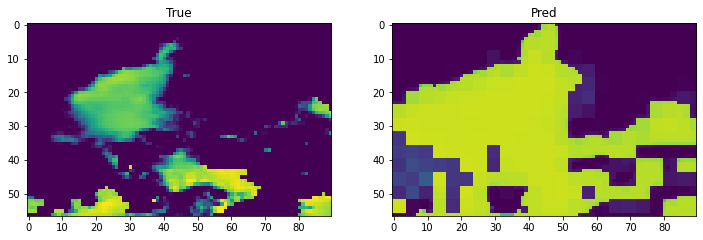

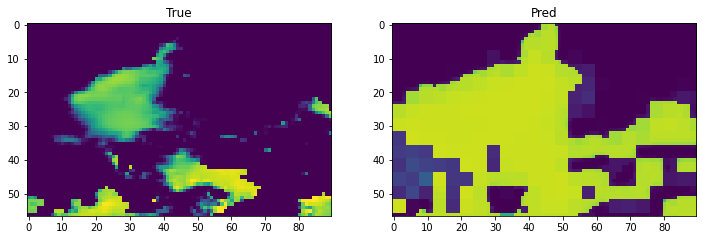

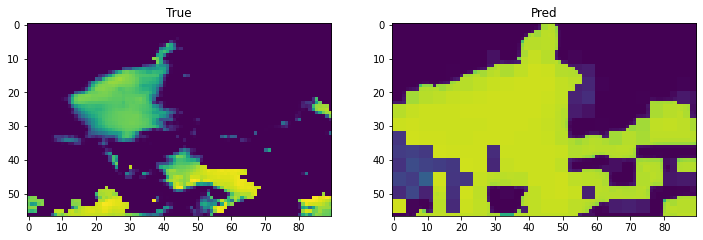

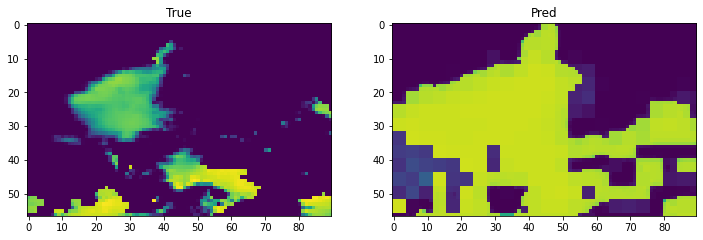

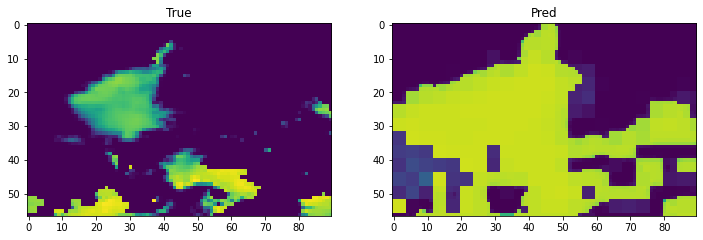

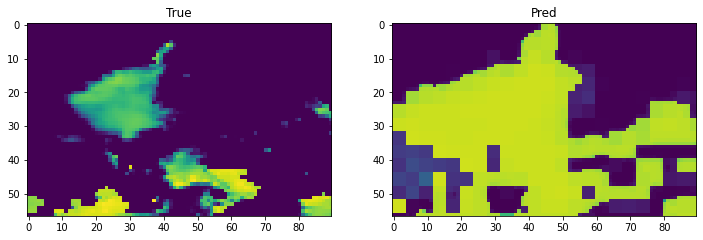

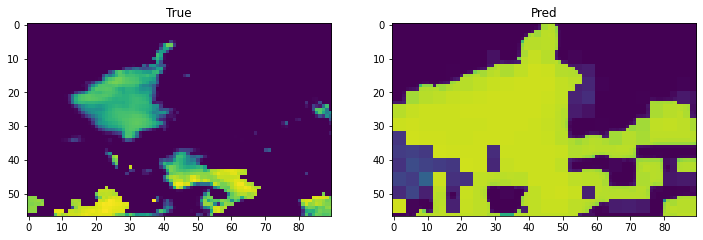

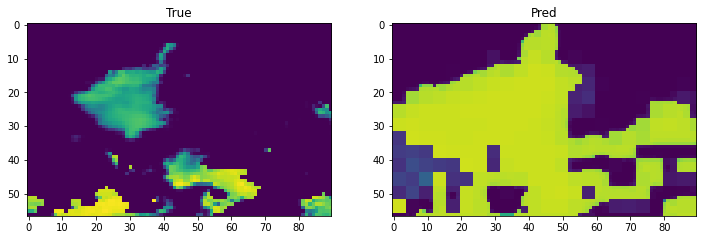

In [68]:
for i in range(ar_steps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(y_val[launch_step + i].squeeze((0, -1)), vmin=0, vmax=1)
    axs[1].imshow(y_hat.squeeze(0)[i], vmin=0, vmax=1)
    axs[0].set_title('True')
    axs[1].set_title('Pred')
    plt.savefig(f'ice_results/example_{i}.png')
    plt.show()